In [2]:
# Importing Data Manipulation Libraries
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# importing Warnings
import warnings
warnings.filterwarnings("ignore")

# Importing Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor , AdaBoostRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

In [3]:
# Loading Dataset

df = pd.read_csv('/Users/anirudhajohare/House_Prices_Prediction_MLModel/research/train.csv')

df.sample(frac=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
744,745,120,RL,41.0,5395,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2008,WD,Normal,180000
214,215,60,RL,NaN,10900,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,450,3,2010,WD,Normal,161750
1126,1127,120,RL,53.0,3684,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,174000
1302,1303,60,RL,92.0,10120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,290000
1197,1198,75,RM,65.0,8850,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,7,2006,ConLw,Normal,144000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,368,80,RL,101.0,9150,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,165000
1444,1445,20,RL,63.0,8500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,179600
195,196,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,148500
315,316,60,RL,71.0,7795,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,188500


# findings :
Rows: 1460

Columns: 81

The dataset includes features describing houses: lot size, neighborhood, year built, type of sale, etc.

Target variable: SalePrice 

In [ ]:
# checking for numerical and categorical variables
df.dtypes.value_counts()

object     43
int64      35
float64     3
Name: count, dtype: int64

Around 43 numeric columns (integers and floats).

Around 38 categorical columns (object types)

It's important because:

Numeric columns → Analyze using stats (mean, median, std, correlation).

Categorical columns → Analyze using frequencies, category vs target plots.

In [ ]:
# checking for null values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_values

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

 Insights:

Some features are missing almost completely (PoolQC, Alley, Fence, etc.).

Garage and basement features have moderate missing values.

 What this means:

Columns with >80-90% missing → Probably drop them.

Columns with moderate missing values → Impute (fill missing) using domain knowledge 

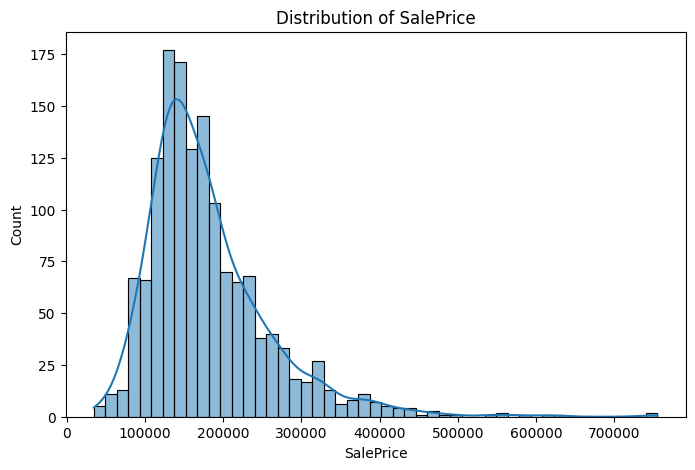

In [ ]:
# target variable distribution --> How salesprice is distributed

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()


What we find:
- SalePrice is right-skewed (long tail to the right).

- Most houses are sold between $100,000 - $300,000.

Insight:

Because of skewness, later on we may apply a log transformation to SalePrice to make it more normal.
(Helps improve model performance.)

In [8]:
# analyzing numerical features
# Checking Summary statistics and Outliers for numeric features
from collections import OrderedDict

stats = []

# Descriptive statistics
for col in df.columns:
    if df[col].dtype != 'object':
        numerical_stats = OrderedDict({
            'Feature': col,
            'Minimum': df[col].min(),
            'Maximum': df[col].max(),
            'Mean': df[col].mean(),
            'Mode': df[col].mode()[0] if not df[col].mode().empty else None,
            '25%': df[col].quantile(0.25),
            '75%': df[col].quantile(0.75),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Standard Deviation': df[col].std(),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurt()
        })
        stats.append(numerical_stats)

# Convert to DataFrame
report = pd.DataFrame(stats)

# Outlier Identification :
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

# Checking Report
report

,Feature,Minimum,Maximum,Mean,Mode,25%,75%,IQR,Standard Deviation,Skewness,Kurtosis,Outlier Comment
0,Id,1.0,1460.0,730.500000,1.0,365.75,1095.25,729.50,421.610009,0.000000,-1.200000,No Outliers
1,MSSubClass,20.0,190.0,56.897260,20.0,20.00,70.00,50.00,42.300571,1.407657,1.580188,Has Outliers
2,LotFrontage,21.0,313.0,70.049958,60.0,59.00,80.00,21.00,24.284752,2.163569,17.452867,Has Outliers
3,LotArea,1300.0,215245.0,10516.828082,7200.0,7553.50,11601.50,4048.00,9981.264932,12.207688,203.243271,Has Outliers
4,OverallQual,1.0,10.0,6.099315,5.0,5.00,7.00,2.00,1.382997,0.216944,0.096293,Has Outliers
5,OverallCond,1.0,9.0,5.575342,5.0,5.00,6.00,1.00,1.112799,0.693067,1.106413,Has Outliers
6,YearBuilt,1872.0,2010.0,1971.267808,2006.0,1954.00,2000.00,46.00,30.202904,-0.613461,-0.439552,Has Outliers
7,YearRemodAdd,1950.0,2010.0,1984.865753,1950.0,1967.00,2004.00,37.00,20.645407,-0.503562,-1.272245,No Outliers
8,MasVnrArea,0.0,1600.0,103.685262,0.0,0.00,166.00,166.00,181.066207,2.669084,10.082417,Has Outliers
9,BsmtFinSF1,0.0,5644.0,443.639726,0.0,0.00,712.25,712.25,456.098091,1.685503,11.118236,Has Outliers


- Features like GrLivArea, TotalBsmtSF, and 1stFlrSF have large means and standard deviations.

- There are some huge max values, hinting at possible outliers.

In [ ]:
# Correlation Analysis  --> which numeric features are most correlated with SalePrice

# Select only numeric features
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Now compute the correlation matrix
corr_matrix = numeric_df.corr()

# Top 10 correlations with SalePrice
top_corr = corr_matrix['SalePrice'].sort_values(ascending=False).head(11)
print(top_corr)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


Insights:

- OverallQual (Overall material and finish quality) is the most important predictor!

- GrLivArea (Above ground living area) is also very strongly related to price.

- Newer houses (YearBuilt) are generally more expensive.

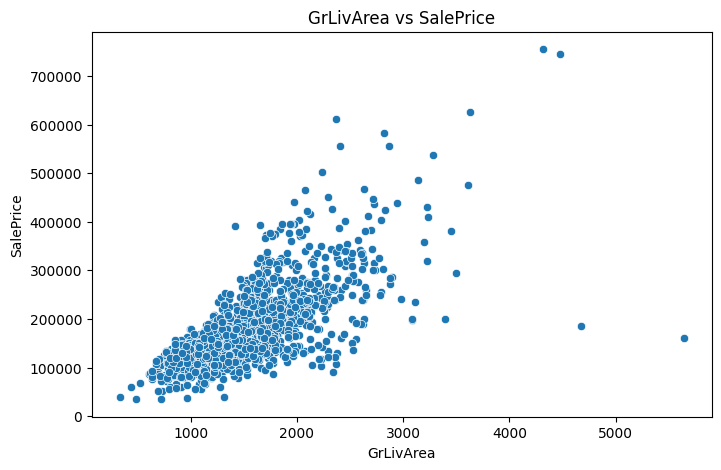

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'])
plt.title('GrLivArea vs SalePrice')
plt.show()
